In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

print(tf.__version__)


2.11.0


### Retrieve the data from the local datasets folder


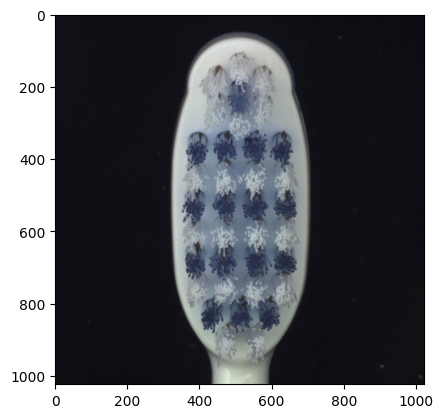

In [2]:
import os

TOOTHBRUSH_DATA_PATH = 'datasets/toothbrush'

TOOTHBRUSH_TRAIN_PATH = os.path.join(TOOTHBRUSH_DATA_PATH, 'train')
TOOTHBRUSH_GOOD_PATH = os.path.join(TOOTHBRUSH_TRAIN_PATH, 'good')

import matplotlib.pyplot as plt

import random

random_img = random.choice(os.listdir(TOOTHBRUSH_GOOD_PATH))

from skimage.io import imread
from skimage.transform import resize

sample_image = imread(os.path.join(TOOTHBRUSH_GOOD_PATH, random_img))
sample_image= sample_image.astype("float32")

plt.imshow(sample_image.astype('uint8'));


In [3]:
sample_image.shape

(1024, 1024, 3)

In [4]:
import numpy as np

def my_init(shape=(5, 5, 3, 3), dtype=None):
    array = np.zeros(shape=shape, dtype="float32")
    array[:, :, 0, 0] = 1 / 25
    array[:, :, 1, 1] = 1 / 25
    array[:, :, 2, 2] = 1 / 25
    return array

# convolutional layer to make the image smaller and extract features
conv = tf.keras.layers.Conv2D(filters=3, kernel_size=(5, 5), input_shape=(None, None, 3), kernel_initializer=my_init)

# spatial pyramid pooling layer
spp = tf.keras.layers.MaxPooling2D(pool_size=(4, 4))

# use the convolutional layer to extract features
img_in = tf.expand_dims(sample_image, axis=0)

img_in.shape

TensorShape([1, 1024, 1024, 3])

In [5]:
img_out = conv(img_in)
img_out = spp(img_out)

img_out.shape

TensorShape([1, 255, 255, 3])

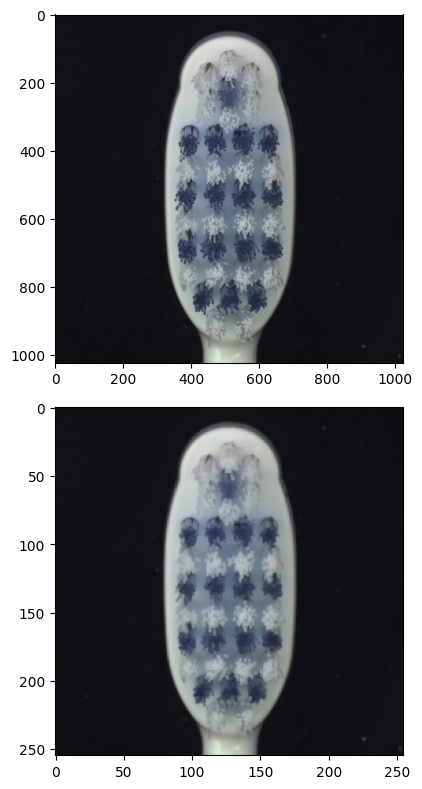

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

fig.tight_layout()
ax[0].imshow(img_in[0].numpy().astype('uint8'))
ax[1].imshow(img_out[0].numpy().astype('uint8'));

### Creating the model

(1, 1024, 1024, 3)
1/1 [==============================] - 0s 103ms/step


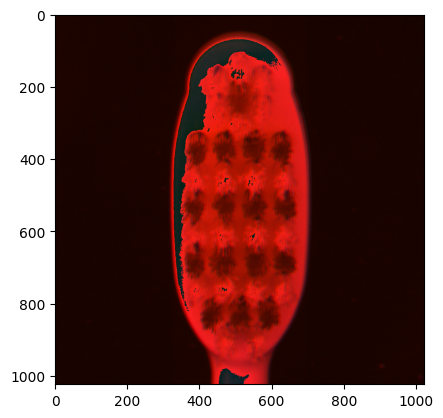

In [59]:
from sspcab import sspcab_layer
tf.data.experimental.enable_debug_mode()

class SPP(tf.keras.models.Model):
    def __init__(self, pool_size=(4, 4)):
        super(SPP, self).__init__()
        
        self.conv = tf.keras.layers.Conv2D(filters=3, kernel_size=(5, 5), input_shape=(1024, 1024, 3), kernel_initializer=my_init)
        self.pool = tf.keras.layers.MaxPooling2D(pool_size=pool_size)
        

    def call(self, inputs, training=False):
        print(inputs.shape)

        # currently not working
        # why? because the input shape is not known at compile time (best guess), so the weights cannot be initialized
        y = sspcab_layer(inputs, name='ssbcap_0', kernel_dim=2, dilation=1, filters=3)
        
        return y

model = SPP()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


prediction = model.predict(img_in, steps=1) 

prediction.shape

# the prediction is a binary classification of the image
# check if the model outputted good or bad

plt.imshow(prediction[0].astype('uint8'));


# reference: https://stackoverflow.com/questions/53804330/image-classification-using-keras-cnn-training-very-slowly
# for image preprocessing and augmentation to increase the number of training samples 
# also for data splitting into training and validation sets and loading the data into the model slowly
